In [ ]:
spark.stop()

# Set paths

DEVEL_SRC must contain the directory use-cases and pykhaos

In [1]:
import os, sys
import datetime as dt
DEVEL_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "src", "devel")
if DEVEL_SRC not in sys.path:
    sys.path.append(DEVEL_SRC)

USECASES_SRC = os.path.join(DEVEL_SRC, "use-cases") # TODO when '-' is removed from name, remove also this line and adapt imports 
if USECASES_SRC not in sys.path: 
    sys.path.append(USECASES_SRC)
    
# AMDOCS_SRC = os.path.join(DEVEL_SRC, "amdocs_informational_dataset") # TODO when - is removed, remove also this line and adapt imports
# if AMDOCS_SRC not in sys.path: 
#     sys.path.append(AMDOCS_SRC)
    
import pykhaos.utils.custom_logger as clogger
logging_file = os.path.join(os.environ.get('BDA_USER_HOME', ''), "logging",
                                    "out_" + dt.datetime.now().strftime("%Y%m%d_%H%M%S") + ".log")
logger = clogger.configure_logger(log_filename=logging_file, std_channel=sys.stderr, logger_name="")
logger.info("Logging to file {}".format(logging_file))    
        
from project.project_generic import Project

import pykhaos.utils.notebooks as nb

import time
start_time = time.time()

RUNNING_FROM_NOTEBOOK = nb.isnotebook()
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
if RUNNING_FROM_NOTEBOOK:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline  
    EXTERNAL_LIB = os.path.join(os.environ.get('BDA_USER_HOME', ''), "lib", "external_libs")
    if EXTERNAL_LIB not in sys.path:
        sys.path.append(EXTERNAL_LIB)
    # feel free from commenting this line and the other ones that begin with "%%notify" if you do not have 
    # the extension installed or copy de lib from /var/SP/data/home/csanc109/lib/external_libs/jupyternotify/
    %load_ext jupyternotify 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

20190730-084141 [INFO ] Logging to file /var/SP/data/home/csanc109/logging/out_20190730_084141.log


<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from pyspark.sql import Row, DataFrame, Column, Window
from pyspark.sql.types import DoubleType, StringType, IntegerType, DateType, ArrayType
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import collect_set, concat, size, coalesce, col, lpad, struct, count as sql_count, lit, min as sql_min, max as sql_max, collect_list, udf, when, desc, asc, to_date, create_map, sum as sql_sum
from pyspark.sql.types import StringType, ArrayType, MapType, StructType, StructField, IntegerType
from pyspark.sql.functions import array, regexp_extract
from itertools import chain
from churn.datapreparation.general.data_loader import get_unlabeled_car, get_port_requests_table, get_numclients_under_analysis
from churn.utils.constants import PORT_TABLE_NAME
from churn.utils.udf_manager import Funct_to_UDF
from pyspark.sql.functions import substring, datediff, row_number
from pykhaos.utils.date_functions import move_date_n_days, move_date_n_cycles
from pykhaos.utils.hdfs_functions import check_hdfs_exists
from pykhaos.modeling.model_performance import get_lift

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Functions

## Start spark context

In [5]:
from churn.utils.general_functions import init_spark
spark = init_spark("triggers_miniIDS")
sc = spark.sparkContext

Ended spark session: 35.3226728439 secs | default parallelism=2


In [ ]:

# from pykhaos.utils.pyspark_utils import count_nans
# A = count_nans(trdf)
# A

def get_metrics(df_preds, label="", nb_deciles=10):
    
    preds_and_labels = df_preds.select(['model_score', 'label']).rdd.map(lambda r: (r['model_score'], float(r['label'])))

    my_metrics = BinaryClassificationMetrics(preds_and_labels)

    print("METRICS FOR {}".format(label))
    print("\t AUC = {}".format(my_metrics.areaUnderROC))
    if nb_deciles:
        lift = get_lift(df_preds, 'model_score', 'label', nb_deciles)

        for d ,l in lift:
            print "\t" + str(d) + ": " + str(l)


def plot_hist(data):
    
    import numpy as np
    import matplotlib.pyplot as mplt
    import matplotlib.ticker as mtick
    
    binSides, binCounts = data

    N = len(binCounts)
    ind = np.arange(N)
    width = 1

    fig, ax = mplt.subplots()
    rects1 = ax.bar(ind+0.5, binCounts, width, color='b')

    ax.set_ylabel('Frequencies')
    ax.set_title('Histogram')
    ax.set_xticks(np.arange(N+1))
    ax.set_xticklabels(binSides)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

    mplt.show()
    

# Input params

In [ ]:
closing_day = "20190414"
start_date = closing_day
end_date = move_date_n_days(closing_day, n=+30)

ref_date = end_date

# Config 

In [ ]:
# int_feats =  ['ccc_num_interactions', 'ccc_num_ivr_interactions', 'device_days_since_device_n1_change_date', 'device_tenure_days_n2'] 
# float_feats = ['additional_inc_bill_n1_n2_net', 'additional_inc_bill_n1_n3_net', 'additional_inc_bill_n1_n4_net', "total_data_volume", "total_mou"]# "total_mou_w", "total_mou_we"] 

from churn.analysis.triggers.get_ids_for_analysis import get_mini_ids, get_sel_cols

numerical_feats = get_sel_cols().values()

noninf_feats = ['NIF_CLIENTE']

label_col = 'label'

COLS = numerical_feats + noninf_feats + [label_col]

feat_cols = numerical_feats # notebook is not still prepared for categoricals.



In [ ]:
df_orders_sla = spark.read.load("/data/attributes/vf_es/trigger_analysis/orders_sla_sintraslados/year=2019/month=4/day=14")
df_orders_sla.select("nb_started_orders_last90").distinct().show()

# Get current car (for train and test) and other car (for validation)

In [ ]:
from churn.analysis.triggers.get_ids_for_analysis import get_mini_ids, get_sel_cols
from churn.analysis.triggers.run_groupby_analysis import filter_car
closing_day = "20190414"

path_to_minids = "/data/attributes/vf_es/trigger_analysis/mini_ids/year={}/month={}/day={}".format(int(closing_day[:4]),
                                                                          int(closing_day[4:6]),
                                                                          int(closing_day[6:]))
df_tar_all = spark.read.parquet(path_to_minids)
df_tar = filter_car(df_tar_all)

In [ ]:
from churn.analysis.triggers.get_ids_for_analysis import get_mini_ids, get_sel_cols

closing_day_2 = "20190507"
path_to_minids = "/data/attributes/vf_es/trigger_analysis/mini_ids/year={}/month={}/day={}".format(int(closing_day_2[:4]),
                                                                          int(closing_day_2[4:6]),
                                                                          int(closing_day_2[6:]))
df_next_tar_all = spark.read.parquet(path_to_minids)
df_next_tar = filter_car(df_tar_all)

# Train them first model to extract important variables

In [ ]:
[df_unbaltr, df_tt] = df_tar.randomSplit([0.7, 0.3], 1234)

#print "[Info FbbChurn] " + time.ctime() + " Total number of training samples is : " + str(unbaltrdf.count())

df_unbaltr.describe('label').show()

print " Stat description of the target variable printed above"

# 1.2. Balanced df for training

df_unbaltr.groupBy('label').agg(sql_count('*')).show()

print " Count on label column for unbalanced tr set showed above"

from churn.models.fbb_churn_amdocs.utils_general import balance_df2
df_tr = balance_df2(df_unbaltr, 'label')

df_tr.groupBy('label').agg(sql_count('*')).show()

print " Count on label column for balanced tr set showed above"

# 1.3. Feature selection

# allFeats = trdf.columns

for f in noninf_feats:
    print "Non-informative feat: " + f


# Model

In [ ]:

logger.info("Feat cols = {}".format(",".join(feat_cols)))

assembler = VectorAssembler(inputCols = feat_cols, outputCol = "features")

classifier = RandomForestClassifier(featuresCol="features", \
                                    labelCol="label", \
                                    maxDepth=25, \
                                    maxBins=32, \
                                    minInstancesPerNode=50, \
                                    impurity="gini", \
                                    featureSubsetStrategy="sqrt", \
                                    subsamplingRate=0.7, \
                                    numTrees=250, \
                                    seed = 1234)

pipeline = Pipeline(stages= [assembler, classifier])

model = pipeline.fit(df_tr)

from churn.models.fbb_churn_amdocs.utils_model import getOrderedRelevantFeats
feat_importance = getOrderedRelevantFeats(model, feat_cols, 'f', 'rf')

for fimp in feat_importance:
    print "Imp feat " + str(fimp[0]) + ": " +  str(fimp[1])

# EVALUATION
# TODO: to include model calibration

# Calibration
#calibmodel = get_calibration_function2(spark, model, valdf, 'label', 10)
#getScore = udf(lambda prob: float(prob[1]), DoubleType())

getScore = udf(lambda prob: float(prob[1]), DoubleType())

# Train evaluation
df_tr_preds = model.transform(df_tr).withColumn("model_score", getScore(col("probability")).cast(DoubleType()))
#trPredictionAndLabels = df_tr_preds.select(['model_score', 'label']).rdd.map(lambda r: (r['model_score'], float(r['label'])))


# Test eval
df_tt_preds = model.transform(df_tt).withColumn("model_score", getScore(col("probability")).cast(DoubleType()))

# Evaluation 
df_val_preds = model.transform(df_next_tar).withColumn("model_score", getScore(col("probability")).cast(DoubleType()))




In [ ]:
# Validation
get_metrics(df_tr_preds, label="train", nb_deciles=None)
get_metrics(df_tt_preds, label="test",  nb_deciles=None)
get_metrics(df_val_preds, label="validation",  nb_deciles=None)

# Evaluation

In [ ]:
# Checking scores

In [ ]:
    
# plot_hist(df_tr_preds.select("model_score").rdd.flatMap(lambda x: x).histogram(50))
# plot_hist(df_tt_preds.select("model_score").rdd.flatMap(lambda x: x).histogram(50))
# plot_hist(df_val_preds.select("model_score").rdd.flatMap(lambda x: x).histogram(50))


In [ ]:

for col_ in numerical_feats:

    n = 50
    bins, counts = df_tr_preds.where(col('label') == 0).select(col_).rdd.flatMap(lambda x: x).histogram(n)

    bins2, counts2 = df_tr_preds.where(col('label') == 1).select(col_).rdd.flatMap(lambda x: x).histogram(n)

    plt.figure()
    plt.hist(bins[:-1], bins=bins, weights=counts)
    plt.hist(bins2[:-1], bins=bins2, weights=counts2)
    plt.xlabel(col_)

In [ ]:
#%matplotlib inline  

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_features_churn_seaborn_shade2(df, var_to_plot, label,  image_per_row = 3, hist = False):
    plt.figure()
    inf = df.filter(df[label] == 0)
    sup = df.filter(df[label] == 1)
    inf.cache()
    sup.cache()
    fig_cat, axes = plt.subplots(int(np.round(len(var_to_plot)/ image_per_row)), image_per_row, figsize=(40, 10*int(np.round(len(var_to_plot)/ image_per_row))), squeeze=False)
    for i, ax in enumerate(fig_cat.axes):
        sel_ = var_to_plot[i]
        print(var_to_plot[i])

        arr = [float(row[sel_]) for row in inf.select(sel_).collect()]
        sns.kdeplot(arr, shade= True, color = 'blue', ax=axes[int(i/image_per_row)][i%image_per_row])
        #print("Half subplot")
        arr2 = [float(row[sel_]) for row in sup.select(sel_).collect()]
        sns.kdeplot(arr2, shade= True, color = 'red', ax=axes[int(i/image_per_row)][i%image_per_row])
        
        axes[int(i/image_per_row)][i%image_per_row].set_title(sel_)
    inf.unpersist()
    sup.unpersist()

    
plot_features_churn_seaborn_shade2(df_tr, var_to_plot=["ccc_num_interactions", "additional_inc_bill_n1_n4_net", "device_days_since_device_n1_change_date"], label="label", image_per_row = 3, hist = False)



# Decision tree

### Fit a decision tree classifier and extract metrics for tr, tt and val

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from churn.models.fbb_churn_amdocs.utils_general import balance_df2


df_tar = df_tar.where(col("segment_nif").isin(["Mobile_only", "Convergent"]))
df_next_tar = df_next_tar.where(col("segment_nif").isin(["Mobile_only", "Convergent"]))

df_tar = df_tar.withColumn("mean_price_rgu", when(col("nb_rgus")!=0, col("Bill_N1_Amount_To_Pay")/col("nb_rgus")).otherwise(-1))
df_next_tar = df_next_tar.withColumn("mean_price_rgu", when(col("nb_rgus")!=0, col("Bill_N1_Amount_To_Pay")/col("nb_rgus")).otherwise(-1))
df_next_tar = df_next_tar.withColumn("segment_idx", when(col("segment_nif")=="Mobile_only", 0).otherwise(1))
df_tar = df_tar.withColumn("segment_idx", when(col("segment_nif")=="Mobile_only", 0).otherwise(1))




assemblerInputs = ["tgs_days_until_fecha_fin_dto", "diff_rgus_n_n2", "blindaje", "nb_started_orders_last30", "mean_price_rgu"]


#assemblerInputs = feat_cols

[df_unbaltr, df_tt] = df_tar.randomSplit([0.7, 0.3], 1234)
df_tr = balance_df2(df_unbaltr, 'label')



assembler_simple = VectorAssembler(inputCols=assemblerInputs, outputCol="features_simple")
pipeline = Pipeline(stages = [assembler_simple])
pipelineModel = pipeline.fit(df_tr.select(assemblerInputs))

df_tr_dtree = pipelineModel.transform(df_tr)

# selectedCols = ['label', 'features_simple'] #+ cols
# df_tr_pipe = df_tr_preds_dtree.select(selectedCols)
# df_tr_pipe.printSchema()

#df_tr_preds_dtree.groupBy('label').agg(sql_count('*')).show()

dtree = DecisionTreeClassifier(featuresCol = 'features_simple', labelCol = 'label', maxDepth = 10, minInstancesPerNode=5000, maxBins=5, minInfoGain=0)
dtree_model = dtree.fit(df_tr_dtree)

#print("Train Area Under ROC: " + str(evaluator.evaluate(df_tr_preds_dtree, {evaluator.metricName: "areaUnderROC"})))

df_tr_preds_dtree = dtree_model.transform(pipelineModel.transform(df_tr))

#df_tt_preds_dtree = dtree_model.transform(pipelineModel.transform(df_tt))
df_val_preds_dtree = dtree_model.transform(pipelineModel.transform(df_next_tar))

evaluator = BinaryClassificationEvaluator()

print("Train Area Under ROC: " + str(evaluator.evaluate(df_tr_preds_dtree, {evaluator.metricName: "areaUnderROC"})))

#print("Test Area Under ROC: " + str(evaluator.evaluate(df_tt_preds_dtree, {evaluator.metricName: "areaUnderROC"})))
print("Val Area Under ROC: " + str(evaluator.evaluate(df_val_preds_dtree, {evaluator.metricName: "areaUnderROC"})))


## Print decision rules

In [ ]:
import re
explanation = dtree_model.toDebugString.splitlines()
for i in range(0, len(assemblerInputs)):
    for ii_ll in range(0, len(explanation)):
        explanation[ii_ll] = explanation[ii_ll].replace("feature {}".format(i), "'{}'".format(assemblerInputs[i]))
#         explanation[ii_ll] = re.sub("Predict: 0.0", "Predict: NO_CHURN", explanation[ii_ll])
        explanation[ii_ll] = re.sub("Predict: 1.0", "Predict: ***********CHURN", explanation[ii_ll])
explanation

# Manual segmentation - discretización

Add variables to compute the churn rate both individually and ijn groups of 2, 3 and4 variables

In [ ]:
from churn.analysis.triggers.get_ids_for_analysis import get_mini_ids, get_sel_cols
from churn.analysis.triggers.run_groupby_analysis import filter_car
closing_day = "20190414"
label_col= "label"
path_to_minids = "/data/attributes/vf_es/trigger_analysis/mini_ids/year={}/month={}/day={}".format(int(closing_day[:4]),
                                                                          int(closing_day[4:6]),
                                                                          int(closing_day[6:]))
df_tar_all = spark.read.parquet(path_to_minids)
df_tar_all = df_tar.where(col("segment_nif") != "Pure_prepaid")

df_tar = filter_car(df_tar_all)

from pyspark.ml.feature import QuantileDiscretizer

vars_analysis = "diff_rgus_n_n2:5,num_calls_w2:5,nb_started_orders_last30:0"
#vars_analysis = "mean_price_rgu:2,tgs_days_until_fecha_fin_dto:4,inc_Bill_N1_N4_Amount_To_Pay:3,nb_started_orders_last30:3"
#vars_analysis = "num_calls_w2:3,diff_rgus_n_n2:3,nb_started_orders_last30:3"
#vars_analysis = "nb_rgus:5,num_calls_w2:5,nb_started_orders_last30:0"

# var1:5,var2:3,var3:4
vars_analysis = vars_analysis.split(",")

print(vars_analysis)

var_dict = {vv.split(":")[0]:[vv.split(":")[0] + "_disc", int(vv.split(":")[1])] for vv in vars_analysis}

#df_tar = df_tar.where(col("segment_nif").isin(["Convergent"]))


import pprint
pprint.pprint(var_dict)

for var, cc in var_dict.items(): # cc = ["name of the discretized variable", num_buckets]
    if var == cc[0]:
        print("discrete variable must be different to actual column")
        sys.exit()
    if cc[0] and cc[0] in df_tar.columns:
        print("dropping {}".format(cc[0]))
        df_tar = df_tar.drop(cc[0])

splits_dict = {}
for var, cc in var_dict.items():
    if not var: continue
    if var == "nb_started_orders_last30":
         df_tar = df_tar.withColumn("nb_started_orders_last30_disc", when(col("nb_started_orders_last30") == 0, "orders=0").otherwise("orders>0"))
    elif var == "inc_billing_noinc_rgus":
        df_tar = df_tar.withColumn("inc_billing_noinc_rgus_disc", when(col("inc_billing_noinc_rgus") == 0, "inc_billing_noinc_rgus=0").when(col("inc_billing_noinc_rgus") == 1, "inc_billing_noinc_rgus==1"))
    elif var == "inc_billing_noinc_rgus":
        df_tar = df_tar.withColumn("inc_billing_noinc_rgus_disc", when(col("inc_billing_noinc_rgus") == 0, "inc_billing_noinc_rgus=0").when(col("inc_billing_noinc_rgus") == 1, "inc_billing_noinc_rgus==1"))
    elif var == "num_calls_w2":
        df_tar = df_tar.withColumn("num_calls_w2_disc", when(col("num_calls_w2") == 0, "num_calls_w2=0").otherwise("num_calls_w2>0"))
#     elif var == "num_calls_w4":
#         df_tar = df_tar.withColumn("num_calls_w4_disc", when(col("num_calls_w4") == 0, "num_calls_w4=0").when(col("num_calls_w4") == 1, "num_calls_w4==1").otherwise("num_calls_w4>1"))
        
    elif var == "num_calls_w4":
        df_tar = df_tar.withColumn("num_calls_w4_disc", when(col("num_calls_w4") == 0, "num_calls_w4=0").otherwise("num_calls_w4>0"))#.when(col("num_calls_w4") == 1, "num_calls_w4==1").otherwise("num_calls_w4>1"))
    elif var == "grado_blindaje":
        df_tar = df_tar.withColumn("grado_blindaje_disc", col("grado_blindaje"))
    elif var == "segment_nif":
        df_tar = df_tar.withColumn("segment_nif_disc", col("segment_nif"))
    else:
        for ii in [0, 1]:
            print(var, cc[0])
            discretizer = QuantileDiscretizer(numBuckets=cc[1], inputCol=var, outputCol=cc[0], relativeError=0)
            bucketizer = discretizer.fit(df_tar)
            df_tar = bucketizer.transform(df_tar)
            splits_dict[cc[0]] = bucketizer.getSplits()
            print(bucketizer.getSplits())
            num_buckets = len(bucketizer.getSplits()) - 1
            print("Intento {} ** Bucketizer of variable {} returned {} buckets - requested {}".format(ii, var, num_buckets, cc[1]))
            break
            # if num_buckets < cc[1]:
            #     print("Requested {} buckets. Returned {} buckets".format(cc[1], num_buckets))
            #     df_tar = df_tar.drop(cc[0])
            #     #df_tar = df_tar.withColumn(var, col(var) + lit(0.000001) * randn())
            # else:
            #     break
    
    
import pprint
pprint.pprint(splits_dict)

refprevalence = df_tar.select(label_col).rdd.map(lambda r: r[label_col]).mean()
refprevalence_all = df_tar_all.select(label_col).rdd.map(lambda r: r[label_col]).mean()

In [ ]:
refprevalence

In [ ]:
mysplit

In [ ]:
cc = ["num_calls_w2_disc", None]

df_tar2= df_tar
df_tar2 = df_tar2.withColumn("prueba", col(cc[0]))
mysplit = splits_dict[cc[0]]
labels_dict = {ii:"[{},{})".format(mysplit[ii],mysplit[ii+1]) for ii in range(0, len(mysplit)-1)}
for num,label in labels_dict.items():
    df_tar2 = df_tar2.withColumn("prueba", when(col("prueba")==num, labels_dict[num]).otherwise(col("prueba")))

df_tar2.where(col("num_calls_w2")==0).select("num_calls_w2", "prueba").distinct().show()

In [ ]:
df_tar.select("num_calls_w2_disc").distinct().show()

In [ ]:
df_tar.select("segment_nif").distinct().show()

## All variables

In [ ]:
myvars = [cc[0] for vv, cc in var_dict.items() if cc[0]]

df_GG = df_tar.select(*myvars + ["label"]).groupBy(*myvars).agg(sql_sum("label").alias("num_churners"),  sql_count("label").alias("num_msisdn")).withColumn("churn_rate", col("num_churners")/col("num_msisdn"))

for var,cc in var_dict.items():
    if not var or not cc[0] in splits_dict.keys(): continue
    mysplit = splits_dict[cc[0]]
    labels_dict = {ii:"[{},{})".format(mysplit[ii],mysplit[ii+1]) for ii in range(0, len(mysplit)-1)}
    for num,label in labels_dict.items():
        df_GG = df_GG.withColumn(cc[0], when(col(cc[0])==num, labels_dict[num]).otherwise(col(cc[0])))
                                                       
df_GG = df_GG.withColumn("LIFT", col("churn_rate")/lit(refprevalence))
df_GG = df_GG.withColumn("LIFT_ALL", col("churn_rate")/lit(refprevalence_all)) 
df_GG = df_GG.sort(desc("LIFT"))
df_GG.show(100,truncate=False)

## 1 variable

In [ ]:
for i in range(0, len(myvars)):

    df_GG_simple = df_tar.select(*[myvars[i]] + ["label"]).groupBy(myvars[i]).agg(sql_sum("label").alias("num_churners"),  sql_count("label").alias("num_msisdn")).withColumn("churn_rate", col("num_churners")/col("num_msisdn"))

    for var,cc in var_dict.items():
        if not var or not cc[0] in splits_dict.keys() or not cc[0] in df_GG_simple.columns: continue
        mysplit = splits_dict[cc[0]]
        labels_dict = {ii:"[{},{})".format(mysplit[ii],mysplit[ii+1]) for ii in range(0, len(mysplit)-1)}
        for num,label in labels_dict.items():
            df_GG_simple = df_GG_simple.withColumn(cc[0], when(col(cc[0])==num, labels_dict[num]).otherwise(col(cc[0])))


    df_GG_simple = df_GG_simple.withColumn("LIFT", col("churn_rate")/lit(refprevalence))
    df_GG_simple = df_GG_simple.withColumn("LIFT_ALL", col("churn_rate")/lit(refprevalence_all)) 
    df_GG_simple = df_GG_simple.sort(desc("LIFT"))
    df_GG_simple.show(100,truncate=False)

## 2 variables

In [ ]:
for i in range(0, len(myvars)):
    for j in range(0, len(myvars)):
        if i == j or i>j: continue

        df_GG_simple_2 = df_tar.select(*[myvars[i], myvars[j]] + ["label"]).groupBy(myvars[i],myvars[j]).agg(sql_sum("label").alias("num_churners"),  sql_count("label").alias("num_msisdn")).withColumn("churn_rate", col("num_churners")/col("num_msisdn"))

        for var,cc in var_dict.items():
            if not var or not cc[0] in splits_dict.keys() or not cc[0] in df_GG_simple_2.columns: continue
            mysplit = splits_dict[cc[0]]
            labels_dict = {ii:"[{},{})".format(mysplit[ii],mysplit[ii+1]) for ii in range(0, len(mysplit)-1)}
            for num,label in labels_dict.items():
                df_GG_simple_2 = df_GG_simple_2.withColumn(cc[0], when(col(cc[0])==num, labels_dict[num]).otherwise(col(cc[0])))
                
        df_GG_simple_2 = df_GG_simple_2.withColumn("LIFT", col("churn_rate")/lit(refprevalence))
        df_GG_simple_2 = df_GG_simple_2.withColumn("LIFT_ALL", col("churn_rate")/lit(refprevalence_all)) 
        df_GG_simple_2 = df_GG_simple_2.sort(desc("LIFT"))
        df_GG_simple_2.show(5,truncate=False)

### 3 variables

In [ ]:
for i in range(0, len(myvars)):
    for j in range(0, len(myvars)):
        for k in range(0, len(myvars)):
            if i == j or i == k or j==k or i<j or j<k: continue
            
            df_GG_simple_3 = df_tar.select(*[myvars[i], myvars[j], myvars[k]] + ["label"]).groupBy(myvars[i],myvars[j], myvars[k]).agg(sql_sum("label").alias("num_churners"),  sql_count("label").alias("num_msisdn")).withColumn("churn_rate", col("num_churners")/col("num_msisdn"))
            for var,cc in var_dict.items():
                if not var or not cc[0] in splits_dict.keys() or not cc[0] in df_GG_simple_3.columns: continue
                mysplit = splits_dict[cc[0]]
                labels_dict = {ii:"[{},{})".format(mysplit[ii],mysplit[ii+1]) for ii in range(0, len(mysplit)-1)}
                for num,label in labels_dict.items():
                    df_GG_simple_3 = df_GG_simple_3.withColumn(cc[0], when(col(cc[0])==num, labels_dict[num]).otherwise(col(cc[0])))


            df_GG_simple_3 = df_GG_simple_3.withColumn("LIFT", col("churn_rate")/lit(refprevalence))
            df_GG_simple_3 = df_GG_simple_3.withColumn("LIFT_ALL", col("churn_rate")/lit(refprevalence_all)) 
            df_GG_simple_3 = df_GG_simple_3.sort(desc("LIFT"))
            df_GG_simple_3.show(5,truncate=False)

In [ ]:
### 4 variables

In [ ]:
for i in range(0, len(myvars)):
    for j in range(0, len(myvars)):
        for k in range(0, len(myvars)):
            for z in range(0, len(myvars)):
                if i == j or i == k or j==k or k==z or i==z or i<j or j<k or k<z: continue

                df_GG_simple_4 = df_tar.select(*[myvars[i], myvars[j], myvars[k], myvars[z]] + ["label"]).groupBy(myvars[i],myvars[j], myvars[k], myvars[z]).agg(sql_sum("label").alias("num_churners"),  sql_count("label").alias("num_msisdn")).withColumn("churn_rate", col("num_churners")/col("num_msisdn"))
                for var,cc in var_dict.items():
                    if not var or not cc[0] in splits_dict.keys() or not cc[0] in df_GG_simple_4.columns: continue
                    mysplit = splits_dict[cc[0]]
                    labels_dict = {ii:"[{},{})".format(mysplit[ii],mysplit[ii+1]) for ii in range(0, len(mysplit)-1)}
                    for num,label in labels_dict.items():
                        df_GG_simple_4 = df_GG_simple_4.withColumn(cc[0], when(col(cc[0])==num, labels_dict[num]).otherwise(col(cc[0])))


                df_GG_simple_4 = df_GG_simple_4.withColumn("LIFT", col("churn_rate")/lit(refprevalence))
                df_GG_simple_4 = df_GG_simple_4.withColumn("LIFT_ALL", col("churn_rate")/lit(refprevalence_all)) 
                df_GG_simple_4 = df_GG_simple_4.sort(desc("LIFT"))
                df_GG_simple_4.show(5,truncate=False)

# k-Means Segmentation

https://rsandstroem.github.io/sparkkmeans.html

In [ ]:
from pyspark.ml.clustering import KMeans

clust_feats = ["device_days_since_device_n1_change_date", "ccc_num_interactions", "total_data_volume", "total_mou"]



vecAssembler = VectorAssembler(inputCols=clust_feats, outputCol="features")
df_kmeans = vecAssembler.transform(df_tr).select('msisdn', 'features')


#----

N = 7

cost = np.zeros(N)
for k in range(2,N):
    kmeans = KMeans().setK(k).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans) #.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later

#In [14]:

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,N),cost[2:N])
ax.set_xlabel('k')
ax.set_ylabel('cost')

#----

k = 3 # nb of clusters
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
kmeans_model = kmeans.fit(df_kmeans)
centers = kmeans_model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)
    
#----

transformed = kmeans_model.transform(df_kmeans)
df_pred =  transformed.select('msisdn', 'prediction')
# rows = transformed.collect()
# print(rows[:3])

#---

# df_pred = spark.createDataFrame(rows)
# df_pred.head()

#---


#Join the prediction with the original data

#The x, y, z from the original dataframe can be added to the newly created dataframe by joining the two dataframes on the 'id' column.
# "prediction" is the cluster number

df_pred = df_pred.join(df_tr, 'msisdn')
#df_pred.show()

#----
# !!!!!!!!!!!!!!!!!

pddf_pred = df_pred.toPandas().set_index('msisdn')
pddf_pred.head()

#-----





In [ ]:
from mpl_toolkits.mplot3d import Axes3D


fig_size = [20,9]
plt.rcParams["figure.figsize"] = fig_size
clusters_colors=["red", "yellow", "blue", "green"]
clusters_markers=["o", "^", "x", "."]
N_CLUSTERS = 3
features = clust_feats
for f1 in range(0,len(features)):
    for f2 in range(0,len(features)):
        for f3 in range(0,len(features)):
            if f1==f2 or f2==f3 or f1==f3:
                continue
            print(f1,f2,f3,features[f1],features[f2],features[f3])
            fig = plt.figure()
            ax_all = Axes3D(fig)
            

            for i, c in enumerate(centers):
                print(c[f1], c[f2], c[f3], '$%d$' % i)
                
                #Draw white circles at cluster centers
                _ = ax_all.scatter3D(c[f1], c[f2], c[f3], marker='o', c="white", alpha=1, s=400, edgecolor='k')
                _ = ax_all.scatter3D(c[f1], c[f2], c[f3], marker='$%d$' % i, alpha=1, s=250, edgecolor='k')
             
                data_cluster = pddf_pred[pddf_pred["prediction"] == i]
                _ = ax_all.scatter3D(data_cluster[clust_feats[f1]], data_cluster[clust_feats[f2]], data_cluster[clust_feats[f3]], alpha=0.8, c=clusters_colors[i], marker=clusters_markers[i], edgecolor='k', s=100)


            _ = ax_all.set_xlabel(features[f1]);
            _ = ax_all.set_ylabel(features[f2]);
            _ = ax_all.set_zlabel(features[f3]);

            plt.show()
            break
        break
    


In [ ]:
pddf_pred.groupby("prediction")["NUM_CLIENTE"].count()
#pddf_pred[pddf_pred["prediction"]==1] 

# Trigger de ordenes

## INCREMENTAL

In [ ]:
from churn.analysis.triggers.run_segment_orders import get_car
for couple in [   ("20190414", "20190421"), ("20190521", "20190531"),  ("20190531", "20190607")]:
    print("-----------", couple)
    df_A, _, _ = get_car(spark, couple[0], labeled_mini_ids=True)
    df_B, _, _ = get_car(spark, couple[1], labeled_mini_ids=True)
    df_C = df_A.select("nif_cliente").join(df_B.select("nif_cliente"), ['nif_cliente'], 'right').where(df_A['nif_cliente'].isNull())
    print("RESUMEN", couple[0], couple[1], df_C.count())
    
    


In [ ]:
spark.read.load("/data/attributes/vf_es/trigger_analysis/mini_ids/").groupBy("year", "month", "day").agg(sql_count("*").alias("count")).sort(asc("year"), asc("month"), asc("day")).show()

In [ ]:
from churn.analysis.triggers.customer_master import get_segment, get_segment_anyday, get_target


closing_day = "20190630"

df_seg.columns


In [ ]:
1+2

In [20]:
from churn.analysis.triggers.customer_master import getFbbDxsForCycleList_anyday,get_segment_msisdn_anyday
from pykhaos.utils.date_functions import move_date_n_cycles,move_date_n_days
from pyspark.sql.functions import from_unixtime,unix_timestamp

closing_day = "20190414"

start_port = closing_day
end_port = move_date_n_cycles(closing_day, n=4)

import datetime as dt
from pykhaos.utils.date_functions import move_date_n_cycles,move_date_n_days

start_port = closing_day
end_port = move_date_n_cycles(closing_day, n=4)

import datetime as dt
today_str = dt.datetime.today().strftime("%Y%m%d")
closing_day_2 = end_port

while closing_day_2 > move_date_n_days(today_str, n=-7):
    print("closing_day_2={} > {}".format(closing_day_2, move_date_n_days(today_str, n=-7)))
    closing_day_2 = move_date_n_cycles(closing_day_2, n=-1)

print("Comparison of bases will be done with {} and {}".format(closing_day, closing_day_2))

from churn.models.fbb_churn_amdocs.utils_fbb_churn import getFixPortRequestsForCycleList
#- Solicitudes de baja de fijo
df_sopo_fix = (getFixPortRequestsForCycleList(spark, closing_day, end_port)\
               .withColumn("date_srv", from_unixtime(unix_timestamp(col("FECHA_INSERCION_SGP")), "yyyyMMdd")))

#- Porque dejen de estar en la lista de clientes
df_baja_fix = getFbbDxsForCycleList_anyday(spark,closing_day, closing_day_2)

# mobile portout
window_mobile = Window.partitionBy("msisdn_a").orderBy(desc("days_from_portout"))  # keep the 1st portout

from churn.utils.udf_manager import Funct_to_UDF

start_date_obj = Funct_to_UDF.convert_to_date(start_port)
end_date_obj = Funct_to_UDF.convert_to_date(end_port)

convert_to_date_udf = udf(Funct_to_UDF.convert_to_date, StringType())

from churn.utils.constants import PORT_TABLE_NAME

df_sol_port = (spark.read.table(PORT_TABLE_NAME)
               .where((col("sopo_ds_fecha_solicitud") >= start_date_obj) & (col("sopo_ds_fecha_solicitud") <= end_date_obj))
               .withColumnRenamed("SOPO_DS_MSISDN1", "msisdn_a")
               .withColumnRenamed("SOPO_DS_FECHA_SOLICITUD", "portout_date")
               .withColumn("portout_date", substring(col("portout_date"), 0, 10))
               .withColumn("portout_date", convert_to_date_udf(col("portout_date")))
               .withColumn("ref_date", convert_to_date_udf(concat(lit(closing_day[:4]), lit(closing_day[4:6]), lit(closing_day[6:]))))
               .withColumn("days_from_portout", datediff(col("ref_date"), col("portout_date")).cast("int"))
               .withColumn("rank", row_number().over(window_mobile))
               .where(col("rank") == 1))

df_sol_port = df_sol_port.withColumn("label_mob", lit(1.0))\
                         .withColumnRenamed("msisdn_a", "msisdn")\
                         .withColumn("date_mob", from_unixtime(unix_timestamp(col("portout_date")), "yyyyMMdd")).select("msisdn", "label_mob", "date_mob")

df_services = get_segment_msisdn_anyday(spark, anyday=closing_day).withColumnRenamed("campo2", "msisdn_d")

# 1 if any of the services of this nif is 1 
window_nif = Window.partitionBy("nif_cliente")



#df_target_nifs = df_target_nifs.select("nif_cliente", "label").drop_duplicates()

#df_target_nifs.show()

Comparison of bases will be done with 20190414 and 20190514
[Info getFixPortRequestsForMonth] Wed Jul 17 10:32:35 2019 Port-out requests for fixed services during period 20190414-20190514: 43573
[getFbbDxsForCycleList_anyday] setting desconexion date to 20190429


In [47]:
dates = [  None, None, None]
reasons = ['mob', 'fix', 'fbb']
dates = sorted([(vv, idx) for idx, vv in enumerate(dates) if vv!=None], key=lambda tup: tup[0], reverse=False)
reasons[dates[0][1]] if dates else "None"

'None'

In [51]:
from pyspark.sql.functions import least

def get_churn_reason(dates):

    reasons = ['mob', 'fix', 'fbb']
    dates = sorted([(vv, idx) for idx, vv in enumerate(dates) if vv!=None], key=lambda tup: tup[0], reverse=False)
    return reasons[dates[0][1]] if dates else "None"
    


get_churn_reason_udf = udf(lambda z: get_churn_reason(z), StringType())


df_target_nifs = (df_services.join(df_sopo_fix, ['msisdn_d'], "left")
                    .na.fill({'label_srv': 0.0})
                    .join(df_baja_fix, ['msisdn'], "left")
                    .na.fill({'label_dx': 0.0})
                    .join(df_sol_port, ['msisdn'], "left")
                    .na.fill({'label_mob': 0.0})
                    .withColumn('tmp', when(    (col('label_srv')==1.0) | (col('label_dx')==1.0) | (col('label_mob')==1.0), 1.0).otherwise(0.0))
                    .withColumn("super_min_date_mob", sql_min("date_mob").over(window_nif))
                    .withColumn("super_min_date_fix", sql_min("date_srv").over(window_nif))
                    .withColumn("super_min_date_dx", sql_min("date_dx").over(window_nif))
                    .withColumn("dates_array", array(["super_min_date_mob", "super_min_date_fix", "super_min_date_dx"]))                 
                                                      
                    .withColumn('tmp', when(    (col('label_srv')==1.0) | (col('label_dx')==1.0) | (col('label_mob')==1.0), 1.0).otherwise(0.0))                 
                    .withColumn('label', sql_max('tmp').over(window_nif))
                    .withColumn("churn_date", least(col("super_min_date_mob"), col("super_min_date_fix"), col("super_min_date_dx"))) 
                    .withColumn('reason', get_churn_reason_udf(col('dates_array')))                
                    .drop("tmp", "tmp_date0")
                 )


# days_until_churn: days since closing_day to churn_event (first churn event)
df_target_nifs = (df_target_nifs.withColumn("days_until_churn", when(col("churn_date").isNotNull(), datediff(from_unixtime(unix_timestamp(col("churn_date"), "yyyyMMdd")),
                                                                                                             from_unixtime(unix_timestamp(lit(closing_day), "yyyyMMdd")))).otherwise(-1)))



In [52]:
df_target_nifs.where(col("label")==1.0).sort(desc("nif_cliente"), desc("msisdn")).select("msisdn", "nif_cliente", 
                                                                                         "date_srv", "date_dx", "date_mob", 
                                                                                         "churn_date", "reason").show(30)

+---------------+-----------+--------+--------+--------+---------+----------+------------+------+
|         msisdn|nif_cliente|date_srv| date_dx|date_mob|tmp_date0|churn_date|churn_date_2|reason|
+---------------+-----------+--------+--------+--------+---------+----------+------------+------+
|      674272861|  y7934311n|    null|    null|20190422| 20190422|  20190422|    20190422|   mob|
|      644359333|  fks797052|    null|    null|20190503| 20190503|  20190503|    20190503|   mob|
|   O29077AHP400|  ZTN946260|    null|20190429|    null| 20190429|  20190429|    20190429|   fbb|
|      989262478|  ZTN946260|    null|    null|    null|     null|  20190429|    20190429|   fbb|
|      631670972|  ZTN946260|    null|    null|    null|     null|  20190429|    20190429|   fbb|
|   617450425333|  ZTN946260|    null|    null|    null|     null|  20190429|    20190429|   fbb|
|      993338367|  Z9986797N|    null|    null|    null|     null|  20190429|    20190429|   fbb|
|      678760934|  Z

In [53]:
df_target_nifs = df_target_nifs.select("nif_cliente", "label", "churn_date", "days_until_churn", "reason").drop_duplicates()


# Tasa de evaporacion


In [71]:
closing_day = "20190414"
from churn.analysis.triggers.run_segment_orders import get_car
#from churn.analysis.triggers.customer_master import get_target
df_tar = spark.read.load("/user/csanc109/projects/triggers/trigger_orders_car_0/year=2019/month=4/day=14")


In [72]:
df_cust = spark.read.load("/data/attributes/vf_es/trigger_analysis/customer_master/year=2019/month=4/day=14")
df_cust.columns
# print(df_cust.count(),
#       df_cust.select("nif_cliente").distinct().count(),
#       df_cust.select("nif_cliente", "label", "churn_date", "days_until_churn", "reason").drop_duplicates().count())

['nif_cliente',
 'NUM_CLIENTE',
 'msisdn',
 'rgu',
 'msisdn_d',
 'segment_nif',
 'nb_rgus',
 'rgus_list',
 'nb_tv_services_nif',
 'nb_rgus_cycles_2',
 'rgus_list_cycles_2',
 'label',
 'churn_date',
 'days_until_churn',
 'reason',
 'tgs_days_until_fecha_fin_dto',
 'tgs_has_discount',
 'tgs_target_accionamiento',
 'diff_rgus_n_n2']

In [73]:
[col_ for col_ in df_tar.columns if "reason" in col_]

['reason']

In [74]:
# col("days_until_churn") - days from closing_day to first churn event
# col("first_order_last30") - first order open within the last 30 days
# col("from_1st_order_to_churn") - days since 1st order to churn event
df_tar_churn = df_tar.where(col("label")==1.0).withColumn("from_1st_order_to_churn", col("days_until_churn") + col("first_order_last30"))



In [75]:
df_tar_churn.select("from_1st_order_to_churn").rdd.flatMap(lambda x: x).count()

40488

In [76]:
for col__ in ["fbb", "fix", "mob"]:
        print(col__, df_tar_churn.where(col("reason") != col__).count())

('fbb', 12948)
('fix', 37356)
('mob', 30672)


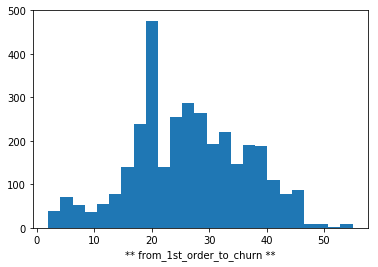

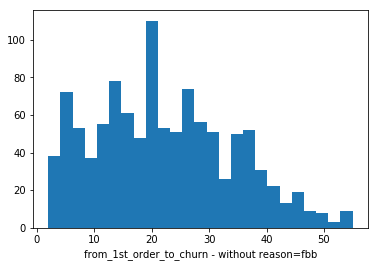

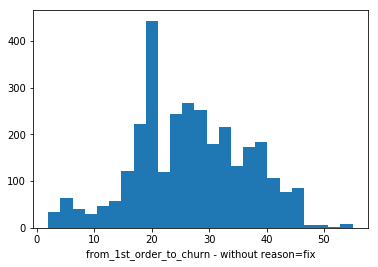

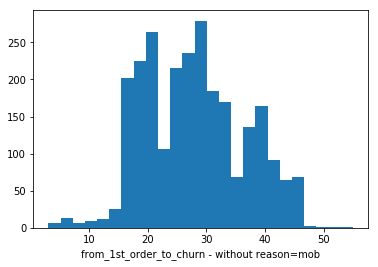

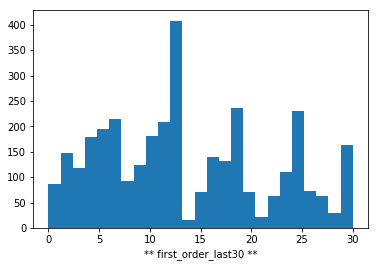

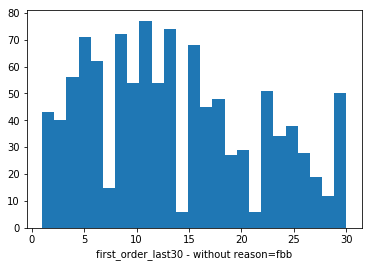

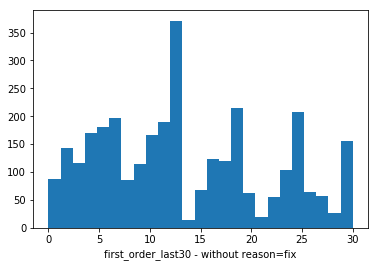

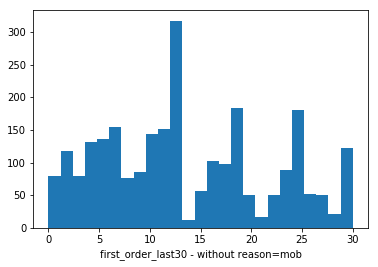

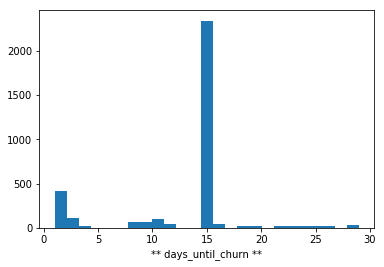

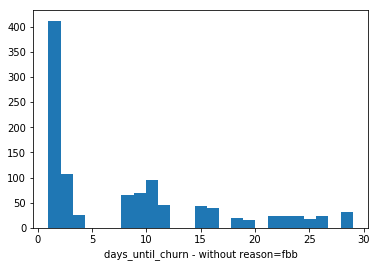

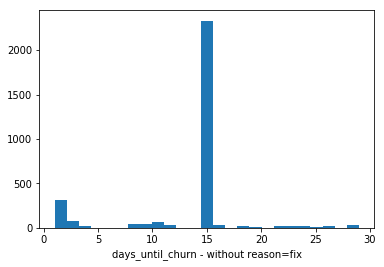

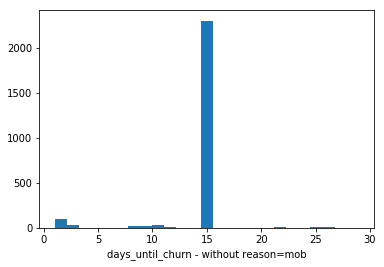

In [31]:
for col_ in ["from_1st_order_to_churn", "first_order_last30", "days_until_churn"]:
    n = 25
    
    bins, counts = df_tar_churn.select(col_).rdd.flatMap(lambda x: x).histogram(n)

    plt.figure()
    plt.hist(bins[:-1], bins=bins, weights=counts)
    plt.xlabel("** {} **".format(col_))
    
    for col__ in ["fbb"]:
        
        bins, counts = df_tar_churn.where(col("reason") != col__).select(col_).rdd.flatMap(lambda x: x).histogram(n)

        plt.figure()
        plt.hist(bins[:-1], bins=bins, weights=counts)
        plt.xlabel("{} - without reason={}".format(col_, col__))

    
    

## histogram + cumsum without reason fbb

Text(0,0.5,'% churners [total churners = 12948]')

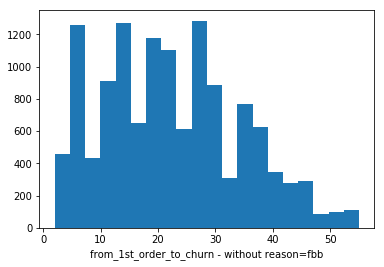

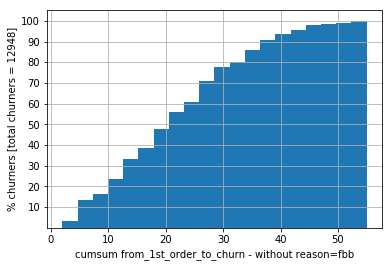

In [95]:
col_ = "from_1st_order_to_churn"
n = 20
col__ = "fbb"

bins, counts = df_tar_churn.where(col("reason") != col__).select(col_).rdd.flatMap(lambda x: x).histogram(n)

plt.figure()
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.xlabel("{} - without reason={}".format(col_, col__))

total = df_tar_churn.where(col("reason") != col__).count()


import numpy as np
counts_cum = np.cumsum(counts)
counts_cum = [100.0 * cc/total for cc in counts_cum]

plt.figure()
plt.hist(bins[:-1], bins=bins, weights=counts_cum)
plt.grid(True)
plt.yticks(list(range(10,110,10))) 
plt.xlabel("cumsum {} - without reason={}".format(col_, col__))
plt.ylabel("% churners [total churners = {}]".format(total))

In [ ]:
[col_ for col_ in spark.read.load("/data/attributes/vf_es/trigger_analysis/orders_sla_ord_esp/year=2019/month=4/day=14").columns if "ord_esp" in col_ and "last30" in col_]

In [ ]:
df_tar_all = spark.read.load("/data/attributes/vf_es/trigger_analysis/customer_master/year=2019/month=4/day=14")
print(df_tar_all.count(), df_tar_all.select("nif_cliente").distinct().count(), df_tar_all.select("nif_cliente", "label", "churn_date", "days_until_churn").drop_duplicates().count())

In [20]:
#last_date = spark.read.parquet('/data/raw/vf_es/customerprofilecar/SERVICESOW/1.1/parquet/').withColumn('mydate', concat(col('year'), lpad(col('month'), 2, '0'), lpad(col('day'), 2, '0'))).select(sql_max(col('mydate')).alias('last_date')).rdd.first()['last_date']



20190721

In [24]:
df_new = (spark.read.parquet('/data/raw/vf_es/customerprofilecar/SERVICESOW/1.1/parquet/')
                   .withColumn('mydate', concat(col('year'), lpad(col('month'), 2, '0'), lpad(col('day'), 2, '0'))))
    
                   
        
df_new.select("mydate").groupby("mydate").agg(sql_count("*").alias("count")).sort(asc("mydate")).show()


+--------+-------+
|  mydate|  count|
+--------+-------+
|20190704|4829526|
|20190705|1349735|
|20190706|2014734|
|20190707| 639412|
|20190708| 261042|
|20190709|1448154|
|20190710|1599751|
|20190711|1590850|
|20190712|1920066|
|20190713|2234086|
|20190714| 912657|
|20190716|2063499|
|20190717|2235981|
|20190718|2076838|
|20190719|2501050|
|20190720|2144195|
|20190721| 911204|
+--------+-------+



In [29]:
spark.read.parquet('/data/raw/vf_es/customerprofilecar/SERVICESOW/1.0/parquet/').printSchema()

Py4JJavaError: An error occurred while calling o639.parquet.
: java.lang.OutOfMemoryError: Java heap space


In [30]:
df_old = (spark.read.parquet('/data/raw/vf_es/customerprofilecar/SERVICESOW/1.0/parquet/').where(col("year")==2019).where(col("month")>=7)
                   .withColumn('mydate', concat(col('year'), lpad(col('month'), 2, '0'), lpad(col('day'), 2, '0'))))
                  
        
df_old.select("mydate").groupby("mydate").agg(sql_count("*").alias("count")).sort(asc("mydate")).show()

Py4JJavaError: An error occurred while calling o644.parquet.
: java.lang.OutOfMemoryError: Java heap space


In [59]:
# import yaml

# CCC_TRAIN_TEST_YAML = os.path.join(USECASES_SRC, "churn", "analysis", 'poc_segments', 'input', 'poc_train_test.yaml')


# input_data = yaml.load(open(CCC_TRAIN_TEST_YAML))



# from churn.analysis.poc_segments.segmentation_data import Segmentation_Data

# P_KEY = ["msisdn"] 
# DP_FILENAME = "/data/udf/vf_es/churn/ccc_model/comercial/df_c20180914_c20190228_n60_comercial_msisdn"
# MODEL_NAME = "poc_segmentation"
# data_abs_data_obj = Segmentation_Data(input_data, filename=DP_FILENAME, pkey_cols=P_KEY, spark=spark)

# MODEL_YAML_PATH = os.path.join(USECASES_SRC, "churn", "analysis", 'poc_segments', 'input', 'pyspark_model.yaml')






# # import datetime as dt
# # from churn.utils.constants import YAML_DATA_PREPARATION, YAML_CLOSING_DAY
# # save_model_path =  os.path.join(SAVING_PATH_UNIQUE, "model")
# # modeler.save(save_model_path)
# # result="OK"
# # "CCC_model_pykahos: [{}] model saved ".format(result)



# # from pykhaos.reporting.reporter import Reporter

# # save_reporter_path = os.path.join(SAVING_PATH_UNIQUE, "reporter")

# # reporter = Reporter(MODEL_NAME, save_model_path, XLSX_REPORT_TEMPLATE_PATH).set_saving_path(save_reporter_path).create()

# # print 'Informe generado!'

# # result="OK"
# # "CCC_model_pykahos: [{}] reporter finished".format(result)


# # GENERATE_PREDICTIONS = True

# # assert(GENERATE_PREDICTIONS)

# # PREDICT_MODEL_NAME = "ccc_comercial_model"
# # PREDICT_MODEL_PATH =  os.path.join(SAVING_PATH, "results", "ccc_comercial", "20181229_203318", "model")
# # closing_day = "20190107" 
# # print("Program will use the model stored at '{}'".format(PREDICT_MODEL_PATH))

# # from churn.models.ccc.delivery.delivery_manager import make_predictions
# # df_lever_predict_hidden = make_predictions(spark, PREDICT_MODEL_NAME, PREDICT_MODEL_PATH, closing_day) # returns a column msisdn (anonymized)

# # print("Prediction size {}".format(df_lever_predict_hidden.count()))
# from pykhaos.modeling.model import Model
# modeler = Model(MODEL_NAME, MODEL_YAML_PATH, verbose=False)
# modeler.fit(data_abs_data_obj)

setting spark
loading data from filename /data/udf/vf_es/churn/ccc_model/comercial/df_c20180914_c20190228_n60_comercial_msisdn
**** Preparing __prepare_data - rows=545935 columns=355
**** After rgu reduction - rows=301137 columns=355
About to remove 69 columns
**** Ended __prepare_datao - rows=301137 columns=286


20190724-104242 [INFO ] df ready to be used!


input_data
{'comment': 'This file is used for training and predict', 'predict': {'do_predict': 'true,', 'closing_day': 20181130}, 'train': {'do_train': True, 'save_train_results': True, 'train_alg': 0}, 'data_preparation': {'agg_by': 'msisdn'}, 'campaign': {'do_campaign': True, 'campaign_date': 201911}}


'\n\nimport datetime as dt\nfrom churn.utils.constants import YAML_DATA_PREPARATION, YAML_CLOSING_DAY\nsave_model_path =  os.path.join(SAVING_PATH_UNIQUE, "model")\nmodeler.save(save_model_path)\nresult="OK"\n"CCC_model_pykahos: [{}] model saved ".format(result)\n\n\n\nfrom pykhaos.reporting.reporter import Reporter\n\nsave_reporter_path = os.path.join(SAVING_PATH_UNIQUE, "reporter")\n\nreporter = Reporter(MODEL_NAME, save_model_path, XLSX_REPORT_TEMPLATE_PATH).set_saving_path(save_reporter_path).create()\n\nprint \'Informe generado!\'\n\nresult="OK"\n"CCC_model_pykahos: [{}] reporter finished".format(result)\n\n\nGENERATE_PREDICTIONS = True\n\nassert(GENERATE_PREDICTIONS)\n\nPREDICT_MODEL_NAME = "ccc_comercial_model"\nPREDICT_MODEL_PATH =  os.path.join(SAVING_PATH, "results", "ccc_comercial", "20181229_203318", "model")\nclosing_day = "20190107" \nprint("Program will use the model stored at \'{}\'".format(PREDICT_MODEL_PATH))\n\nfrom churn.models.ccc.delivery.delivery_manager import m

In [158]:
spark.read.load("/data/attributes/vf_es/trigger_analysis/customer_master/year=2019/").select("month", "day").where(col("month")>4).groupby("month","day").agg(sql_count("*").alias("count")).sort(desc("month"), desc("day")).show()


+-----+---+-------+
|month|day|  count|
+-----+---+-------+
|    7|  9|3835394|
|    7|  8|3836144|
|    7|  7|3836780|
|    6|  7|5402015|
|    5| 31|5418432|
|    5| 21|5435085|
|    5| 14|5447081|
|    5|  7|5461163|
+-----+---+-------+



In [201]:
(spark.read.load("/data/attributes/vf_es/trigger_analysis/customer_master_unlabeled/year=2019/month=7/day=22").select("nif_cliente").distinct().count())

5447081

In [225]:


(spark.read.load("/user/csanc109/projects/triggers/trigger_orders_car_unlabeled/year=2019/").where(col("segment_nif") != "Pure_prepaid").where(col("month")>4).groupby("month","day").agg(sql_count("*").alias("count"),
       sql_sum(when(col("has_superoferta")==0,1)).alias("no_superoferta"), 
       sql_sum(when(col("CHURN_CANCELLATIONS_w8")==0,1)).alias("no_churn_calls"),
       sql_sum(when(col("diff_rgus_n_n2")<0,1)).alias("diff_rgus"),
       sql_sum(when(   (col("has_superoferta")==0) & (col("CHURN_CANCELLATIONS_w8")==0),1)).alias("after_filter1"),
       sql_sum(when(   ((col("has_superoferta")==0) & (col("CHURN_CANCELLATIONS_w8")==0) & (col("nb_started_orders_last30") > 0)), 1)).alias("after_rule_part_1"),
       sql_sum(when(   ((col("has_superoferta")==0) & (col("CHURN_CANCELLATIONS_w8")==0) & (col("diff_rgus_n_n2") < 0)), 1)).alias("after_rule_part_2"),
       sql_sum(when(   ((col("has_superoferta")==0) & (col("CHURN_CANCELLATIONS_w8")==0) & (col("diff_rgus_n_n2") < 0) & (col("nb_started_orders_last30") > 0)), 1)).alias("after_rule_all")
       )
.sort(desc("month"), desc("day")).show())



+-----+---+-------+--------------+--------------+---------+-------------+-----------------+-----------------+--------------+
|month|day|  count|no_superoferta|no_churn_calls|diff_rgus|after_filter1|after_rule_part_1|after_rule_part_2|after_rule_all|
+-----+---+-------+--------------+--------------+---------+-------------+-----------------+-----------------+--------------+
|    7| 23|3856929|       3336207|       3690688|    12734|      3227264|           478685|             8459|          7740|
|    7| 21|3857076|       3340932|       3672100|    11603|      3221901|           459079|             7620|          6874|
|    7|  8|3848842|       3421482|       3691437|    31716|      3315989|           439840|            19271|         14388|
|    6| 30|3852796|       3486870|       3683229|    40118|      3368506|           391784|            24921|         18095|
|    6| 21|3863384|       3549680|       3689749|    56514|      3422777|           389186|            25823|         17772|


In [253]:
(spark.read.load("/data/attributes/vf_es/trigger_analysis/customer_master_unlabeled/year=2019/").select("month", "day", "diff_rgus_n_n2").where(col("month")>4).groupby("month","day")
.agg(sql_count("*").alias("count"),
     sql_sum(when(col("diff_rgus_n_n2")<0,1)).alias("diff_rgus<0")
).sort(desc("month"), desc("day")).show())




+-----+---+-------+-----------+
|month|day|  count|diff_rgus<0|
+-----+---+-------+-----------+
|    7| 23|3856925|      12711|
|    7| 21|3857074|      11643|
|    7| 15|3852807|      20868|
|    7|  8|3848845|      31743|
|    6| 30|3852813|      40084|
|    6| 21|5406554|      65106|
|    6| 14|5393204|      65854|
|    6|  7|5402015|      88094|
|    5| 31|5418432|      83921|
|    5| 21|5435085|      61698|
|    5| 14|5447081|      69194|
+-----+---+-------+-----------+



In [222]:
spark.read.load("/data/attributes/vf_es/trigger_analysis/customer_master/year=2019/").select("month", "day").where(col("month")>4).groupby("month","day").agg(sql_count("*").alias("count")).sort(desc("month"), desc("day")).show()




+-----+---+-------+
|month|day|  count|
+-----+---+-------+
|    7| 15|3852816|
|    7|  9|3835394|
|    7|  8|3836144|
|    7|  7|3836780|
|    6|  7|5402015|
|    5| 31|5418432|
|    5| 21|5435085|
|    5| 14|5447081|
|    5|  7|5461163|
+-----+---+-------+



In [223]:

(spark.read.load("/user/csanc109/projects/triggers/ccc_attributes_w8/year=2019/").select("month", "day", "num_calls_w8", "CHURN_CANCELLATIONS_w8").where(col("CHURN_CANCELLATIONS_w8")==0)
          .withColumn("day", col("day").astype("int")).where(col("month")>4)
          .groupby("month","day").agg(sql_sum("num_calls_w8").alias("calls"),
                                      sql_sum("CHURN_CANCELLATIONS_w8").alias("calls_churn"),
                                      sql_count(when(col("num_calls_w8")>0,1)).alias("nifs_with_calls"),
                                      sql_count(when(col("CHURN_CANCELLATIONS_w8")>0,1)).alias("nifs_with_churn_calls"),
                                      sql_count("*").alias("entries")).sort(desc("month"), desc("day")).show())



+-----+---+-------+-----------+---------------+---------------------+-------+
|month|day|  calls|calls_churn|nifs_with_calls|nifs_with_churn_calls|entries|
+-----+---+-------+-----------+---------------+---------------------+-------+
|    7| 23|1302250|          0|         571291|                    0|3690672|
|    7| 22|1284253|          0|         565045|                    0|3696082|
|    7| 21|1466193|          0|         625615|                    0|3672090|
|    7| 15|1345924|          0|         587242|                    0|3684983|
|    7|  9|1346580|          0|         589985|                    0|3673167|
|    7|  8|1324127|          0|         583002|                    0|3678675|
|    7|  7|1444481|          0|         622717|                    0|3666774|
|    6| 30|1441229|          0|         624556|                    0|3683237|
|    6| 21|1456211|          0|         631994|                    0|3689977|
|    6|  9|1336369|          0|         596555|                 

In [224]:
#spark.read.load("/data/udf/vf_es/amdocs_ids/orders/year=2019/").select("month", "day").where(col("month")>4).groupby("month","day").agg(sql_count("*").alias("count")).sort(desc("month"), desc("day")).show()
spark.read.load("/data/attributes/vf_es/trigger_analysis/orders_sla_csanc109/year=2019/").select("month", "day", "nb_started_orders_last30").withColumn("day", col("day").astype("int")).where(col("month")>4).groupby("month","day").agg(sql_count("*").alias("count"),
sql_sum("nb_started_orders_last30").alias("nb_orders")).sort(desc("month"), desc("day")).show()


+-----+---+-------+---------+
|month|day|  count|nb_orders|
+-----+---+-------+---------+
|    7| 22|6599078|  5908070|
|    7| 21|3288240|  2934607|
|    7|  9|3130915|  2835390|
|    7|  8|3122908|  2815905|
|    7|  7|3097778|  2657047|
|    5| 21|2547681|  2436526|
|    5|  7|2377892|  2098003|
+-----+---+-------+---------+



In [6]:
closing_day_train = "20190307"
closing_day_val = "20190507"
from churn.analysis.poc_segments.Metadata import FEATS
feat_cols = FEATS
noninf_feats = ['msisdn']
label_col = 'label'

COLS = feat_cols + noninf_feats + [label_col]

df_tar = spark.read.load("/user/csanc109/projects/poc_segm/car_orders_calls_w8_h8_d2/year={}/month={}/day={}/".format(int(closing_day_train[:4]), int(closing_day_train[4:6]), int(closing_day_train[6:])))
df_tar.select("segment").groupby("segment").agg(sql_count("segment").alias("count")).show()
df_tar = df_tar.where(col("segment")=="mobileandfbb")
df_tar = df_tar.select(*COLS)

df_next_tar = spark.read.load("/user/csanc109/projects/poc_segm/car_orders_calls_w8_h8_d2/year={}/month={}/day={}/".format(int(closing_day_val[:4]), int(closing_day_val[4:6]), int(closing_day_val[6:])))
df_next_tar.select("segment").groupby("segment").agg(sql_count("segment").alias("count")).show()
df_next_tar = df_next_tar.where(col("segment")=="mobileandfbb")
df_next_tar = df_next_tar.select(*COLS)



+------------+------+
|     segment| count|
+------------+------+
|       other| 23844|
|mobileandfbb|358546|
|     onlymob| 59115|
+------------+------+

+------------+------+
|     segment| count|
+------------+------+
|       other| 26442|
|mobileandfbb|380511|
|     onlymob| 60917|
+------------+------+



### Filter inactive

In [7]:
from churn.datapreparation.general.data_loader import get_active_services
df_active_cd = get_active_services(spark, closing_day_train, new=False, customer_cols=None, service_cols=None)
df_active_cd_val = get_active_services(spark, closing_day_val, new=False, customer_cols=None, service_cols=None)

count_1 = df_tar.count()
df_tar = df_tar.join(df_active_cd.select("msisdn"), on=["msisdn"], how="inner")
count_2 = df_tar.count()

print("df_tar current_count={} inactive={}".format(count_2, count_1 - count_2))


count_1 = df_next_tar.count()
df_next_tar = df_next_tar.join(df_active_cd_val.select("msisdn"), on=["msisdn"], how="inner")
count_2 = df_next_tar.count()

print("df_next_tar current_count={} inactive={}".format(count_2, count_1 - count_2))

df_tar current_count=357059 inactive=1487
df_next_tar current_count=378889 inactive=1622


In [8]:
churn_rate_segm = 100.0 * df_tar.select("label").rdd.map(lambda r: r["label"]).mean()
churn_rate=2.25
print("churn_rate={:.2f} churn_rate_seg={:.2f} LIFT={:.2f}".format(churn_rate, churn_rate_segm, churn_rate_segm / churn_rate))

churn_rate=2.30
churn_rate_segm = 100.0 * df_next_tar.select("label").rdd.map(lambda r: r["label"]).mean()
print("churn_rate={:.2f} churn_rate_seg={:.2f} LIFT={:.2f}".format(churn_rate, churn_rate_segm, churn_rate_segm / churn_rate))


churn_rate=2.25 churn_rate_seg=2.46 LIFT=1.09
churn_rate=2.30 churn_rate_seg=3.07 LIFT=1.33


In [9]:
from churn.datapreparation.app.generate_table_extra_feats_new import impute_nulls
df_tar = impute_nulls(df_tar, spark, metadata_version="1.1")
df_next_tar = impute_nulls(df_next_tar, spark, metadata_version="1.1")


20190730-084815 [INFO ] df_metadata=DataFrame[feature: string, source: string, type: string, imputation: string]
20190730-084819 [INFO ] df_metadata=DataFrame[feature: string, source: string, type: string, imputation: string]
20190730-084823 [INFO ] about to call fillna
20190730-084827 [INFO ] after call to fillna
20190730-084827 [INFO ] df_metadata=DataFrame[feature: string, source: string, type: string, imputation: string]
20190730-084831 [INFO ] df_metadata=DataFrame[feature: string, source: string, type: string, imputation: string]
20190730-084835 [INFO ] about to call fillna
20190730-084838 [INFO ] after call to fillna


In [10]:
from churn.analysis.poc_segments.poc_modeler import get_split, fit
df_unbaltr, df_tr, df_tt = get_split(df_tar, train_split_ratio=0.7)

+-------+--------------------+
|summary|               label|
+-------+--------------------+
|  count|              250150|
|   mean|0.024429342394563264|
| stddev| 0.15437825267228553|
|    min|                 0.0|
|    max|                 1.0|
+-------+--------------------+

 Stat description of the target variable printed above
+-----+--------+
|label|count(1)|
+-----+--------+
|  0.0|  244039|
|  1.0|    6111|
+-----+--------+

 Count on label column for unbalanced tr set showed above
[Info balance_df2] Dataframe has been balanced - Total number of rows is 12257
+-----+--------+
|label|count(1)|
+-----+--------+
|  0.0|    6146|
|  1.0|    6111|
+-----+--------+

 Count on label column for balanced tr set showed above


In [ ]:
print("Lets fit")
start_fit = time.time()
model = fit(df_tr, feat_cols, maxDepth=10, maxBins=32, minInstancesPerNode=50, impurity="gini", featureSubsetStrategy="sqrt", subsamplingRate=0.7, numTrees=50,seed=1234)
print("ended fit - {} min".format( (time.time()-start_time)/60.0))

Lets fit


In [ ]:
model.stages[-1].extractParamMap()

In [ ]:
from churn.analysis.poc_segments.poc_modeler import get_feats_imp
feat_imp_list = get_feats_imp(model, feat_cols, top=25)


In [ ]:
from churn.analysis.poc_segments.poc_modeler import get_score, get_metrics

# Train evaluation
df_tr_preds = get_score(model, df_tr)
#trPredictionAndLabels = df_tr_preds.select(['model_score', 'label']).rdd.map(lambda r: (r['model_score'], float(r['label'])))

# Test eval
df_tt_preds = get_score(model, df_tt)

# Evaluation TODO
df_val_preds = get_score(model, df_next_tar).withColumnRenamed("model_score", "score_segm")


# Validation
get_metrics(df_tr_preds, title="train", nb_deciles=None)
get_metrics(df_tt_preds, title="test",  nb_deciles=None)
get_metrics(df_val_preds, title="validation",  nb_deciles=None, score_col="score_segm")

In [ ]:
from churn.datapreparation.general.model_outputs_manager import get_complete_scores_model_name_closing_day
df_deliv = get_complete_scores_model_name_closing_day(spark, model_name="delivery_churn", closing_day=closing_day_val).select("msisdn", "scoring")
df_deliv = df_deliv.cache()

print("df_deliv= {}".format(df_deliv.count()))
df_deliv = df_deliv.join(df_val_preds.select("msisdn", "label"), on=["msisdn"], how="right")
df_deliv = df_deliv.cache()
count_1 = df_deliv.count()
print("df_deliv= {}".format(count_1))
df_deliv_null = df_deliv.where(col("scoring").isNull())

df_deliv = df_deliv.where(col("scoring").isNotNull())
count_2 = df_deliv.count()
print("df_deliv removed {1} nulls. Current count {0}".format(count_2, count_1-count_2))

get_metrics(df_deliv, title="delivery",  nb_deciles=None, score_col="scoring", label_col="label")

In [ ]:
df_val_preds.where(col("msisdn")=="604415999").count()

In [49]:
df_null_2 = spark.read.table("tests_es.jvmm_amdocs_ids_" + closing_day_val).where(col("msisdn")=="604415999")
[col_ for col_ in df_null_2.columns if "srv_basic" in col_.lower()]                  

['SRV_BASIC', 'DESC_SRV_BASIC', 'FX_SRV_BASIC', 'PRICE_SRV_BASIC']

In [50]:
df_null_2.select("clase_cli_cod_clase_cliente", "cod_estado_general", "srv_basic").show()

+---------------------------+------------------+---------+
|clase_cli_cod_clase_cliente|cod_estado_general|srv_basic|
+---------------------------+------------------+---------+
|                         RS|                01|    MRSUI|
+---------------------------+------------------+---------+



In [69]:
df_deliv_null_complete = df_deliv_null.join(spark.read.table("tests_es.jvmm_amdocs_ids_" + closing_day_val).select("msisdn", "clase_cli_cod_clase_cliente", "cod_estado_general", "srv_basic"), on=["msisdn"], how="left").select("msisdn", "clase_cli_cod_clase_cliente", "cod_estado_general", "srv_basic")

In [70]:
df_deliv_null_complete.select("clase_cli_cod_clase_cliente", "cod_estado_general", "srv_basic").drop_duplicates().show()

+---------------------------+------------------+---------+
|clase_cli_cod_clase_cliente|cod_estado_general|srv_basic|
+---------------------------+------------------+---------+
+---------------------------+------------------+---------+

